In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
import os
import zipfile

from pathlib import Path
import requests
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import os
from tqdm.auto import tqdm


In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


## 1.Getting Data


###1.1 Settting up Device agnostic code

In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##2. Setup the train and test path

In [4]:
train_dir="/kaggle/input/food102/train"
test_dir="/kaggle/input/food102/test"

train_dir,test_dir

('/kaggle/input/food102/train', '/kaggle/input/food102/test')

In [5]:
len(train_dir),len(test_dir)

(27, 26)

###2.1 Create Dataset and DataLoader

In [6]:
from torchvision.models import (
    swin_b,
    Swin_B_Weights
)

# 1. Choose the pretrained weights
weights = Swin_B_Weights.DEFAULT

# 2. Instantiate the model with those weights
model = swin_b(weights=weights)

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:01<00:00, 202MB/s] 


In [7]:
# 3. Grab the associated data‐transform pipeline
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[238]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
#4. Create train_dataset and test_dataset
NUM_WORKERS=os.cpu_count()
train_data=datasets.ImageFolder(train_dir,transform=auto_transform)
test_data=datasets.ImageFolder(test_dir,transform=auto_transform)
len(train_data),len(test_data)

(81600, 20400)

In [9]:
class_names=train_data.classes
len(class_names)

102

In [10]:
# 5. Create your DataLoaders exactly as before, passing in the new auto_transform
train_dataloader=DataLoader(train_data,batch_size=32,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader=DataLoader(test_data,batch_size=32,shuffle=False,num_workers=NUM_WORKERS)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c5d65950b90>,
 <torch.utils.data.dataloader.DataLoader at 0x7c5d7c07d550>)

In [11]:
len(train_dataloader),len(test_dataloader)

(2550, 638)

##3. Getting a pretrained Model

###3.1 Setting up a pretrained Model

In [12]:
from torchvision.models import swin_b, Swin_B_Weights

model = swin_b(weights=weights).to(device)

model


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

###3.2 Getting a summary of model

In [13]:
summary(model,
        (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 7, 7, 1024]      --                   True
│    └─Sequential (0)                                   [1, 3, 224, 224]     [1, 56, 56, 128]     --                   True
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 128, 56, 56]     6,272                True
│    │    └─Permute (1)                                 [1, 128, 56, 56]     [1, 56, 56, 128]     --                   --
│    │    └─LayerNorm (2)                               [1, 56, 56, 128]     [1, 56, 56, 128]     256                  True
│    └─Sequential (1)                                   [1, 56, 56, 128]     [1, 56, 56, 128]     --                   True
│    

###3.3 Freezing the base model and changing the output layer to suit our need

In [14]:
# 1. Freeze everything except the head
for name, param in model.named_parameters():
    # these are the layers used to produce the final class logits
    if not name.startswith("head"):
        param.requires_grad = False

In [15]:
# 2. Replace the existing head
in_features = model.head.in_features   # should be 1024 for swin_b
model.head = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, out_features=len(class_names), bias=True)
).to(device)


In [16]:
summary(model,
        (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [1, 3, 224, 224]     [1, 102]             --                   Partial
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 7, 7, 1024]      --                   False
│    └─Sequential (0)                                   [1, 3, 224, 224]     [1, 56, 56, 128]     --                   False
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 128, 56, 56]     (6,272)              False
│    │    └─Permute (1)                                 [1, 128, 56, 56]     [1, 56, 56, 128]     --                   --
│    │    └─LayerNorm (2)                               [1, 56, 56, 128]     [1, 56, 56, 128]     (256)                False
│    └─Sequential (1)                                   [1, 56, 56, 128]     [1, 56, 56, 128]     --                   Fal

In [17]:
# 3. Check that only your new head’s params require gradients
for name, param in model.named_parameters():
    print(f"{name:40s} | requires_grad={param.requires_grad}")

features.0.0.weight                      | requires_grad=False
features.0.0.bias                        | requires_grad=False
features.0.2.weight                      | requires_grad=False
features.0.2.bias                        | requires_grad=False
features.1.0.norm1.weight                | requires_grad=False
features.1.0.norm1.bias                  | requires_grad=False
features.1.0.attn.relative_position_bias_table | requires_grad=False
features.1.0.attn.qkv.weight             | requires_grad=False
features.1.0.attn.qkv.bias               | requires_grad=False
features.1.0.attn.proj.weight            | requires_grad=False
features.1.0.attn.proj.bias              | requires_grad=False
features.1.0.norm2.weight                | requires_grad=False
features.1.0.norm2.bias                  | requires_grad=False
features.1.0.mlp.0.weight                | requires_grad=False
features.1.0.mlp.0.bias                  | requires_grad=False
features.1.0.mlp.3.weight                | requir

##4 Creating the Training and Testing loop's

###4.1 Setup the loss function and optimizer

In [18]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

###4.2 Setp the Training loop as train_step

In [19]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device):
  model.train()
  train_loss,train_acc=0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)

    y_pred=model(X)

    loss=loss_fn(y_pred,y)

    train_loss+=loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)
  return train_loss,train_acc

###4.3 Setup the Testing loop in test_setup function

In [20]:
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module,
              device:torch.device):
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)

      test_pred=model(X)

      loss=loss_fn(test_pred,y)

      test_loss+=loss.item()

      test_pred_class=test_pred.argmax(dim=1)

      test_acc+=(test_pred_class==y).sum().item()/len(test_pred_class)

  test_loss=test_loss/len(dataloader)

  test_acc=test_acc/len(dataloader)

  return test_loss,test_acc

###4.4 Setup the Train function for training the model

In [21]:
def train(model:nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:nn.Module,
          epochs:int,
          device:torch.device):
  results={"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss,test_acc=test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)
    print(
        f"Epoch:{epoch+1} | Train_loss:{train_loss:.4f} | Train_acc:{train_acc:.4f} | Test_loss:{test_loss:.4f} | Test_acc:{test_acc:.4f}"
    )
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
start_time=timer()
results=train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=10,
             device=device)
end_time=timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1 | Train_loss:1.6581 | Train_acc:0.5865 | Test_loss:1.1612 | Test_acc:0.6952
Epoch:2 | Train_loss:1.2666 | Train_acc:0.6664 | Test_loss:1.0575 | Test_acc:0.7212
Epoch:3 | Train_loss:1.2003 | Train_acc:0.6807 | Test_loss:1.0200 | Test_acc:0.7302
Epoch:4 | Train_loss:1.1750 | Train_acc:0.6873 | Test_loss:0.9980 | Test_acc:0.7368
Epoch:5 | Train_loss:1.1563 | Train_acc:0.6918 | Test_loss:0.9848 | Test_acc:0.7381
Epoch:6 | Train_loss:1.1450 | Train_acc:0.6934 | Test_loss:0.9908 | Test_acc:0.7377
Epoch:7 | Train_loss:1.1427 | Train_acc:0.6949 | Test_loss:0.9667 | Test_acc:0.7447
Epoch:8 | Train_loss:1.1411 | Train_acc:0.6961 | Test_loss:0.9767 | Test_acc:0.7452
Epoch:9 | Train_loss:1.1296 | Train_acc:0.6977 | Test_loss:0.9674 | Test_acc:0.7466
Epoch:10 | Train_loss:1.1337 | Train_acc:0.6972 | Test_loss:0.9492 | Test_acc:0.7500
[INFO] Total training time: 15433.474 seconds


In [23]:
import torch
import os


save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "swin_base_finetuned.pth")

#Save the state dict
torch.save(model.state_dict(), save_path)
print(f"[INFO] Saved model state_dict to {save_path}")


[INFO] Saved model state_dict to ./checkpoints/swin_base_finetuned.pth


In [24]:
# 1. Re-create the model architecture (must match exactly)
from torchvision.models import swin_b, Swin_B_Weights

model = swin_b(weights=None)          # no pretrained weights
# replace head as you did before…
model.head = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1024, out_features=102, bias=True)
)
model.to(device)

# 2. Load the saved weights
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print("[INFO] Model loaded and ready for inference.")


[INFO] Model loaded and ready for inference.


In [25]:
from IPython.display import FileLink

# adjust path if needed
checkpoint_path = "checkpoints/swin_base_finetuned.pth"

# this will render a clickable link in the notebook
display(FileLink(checkpoint_path))


/kaggle/working/checkpoints/swin_base_finetuned.pth

## 5. Evaluate model by plotting loss curves 

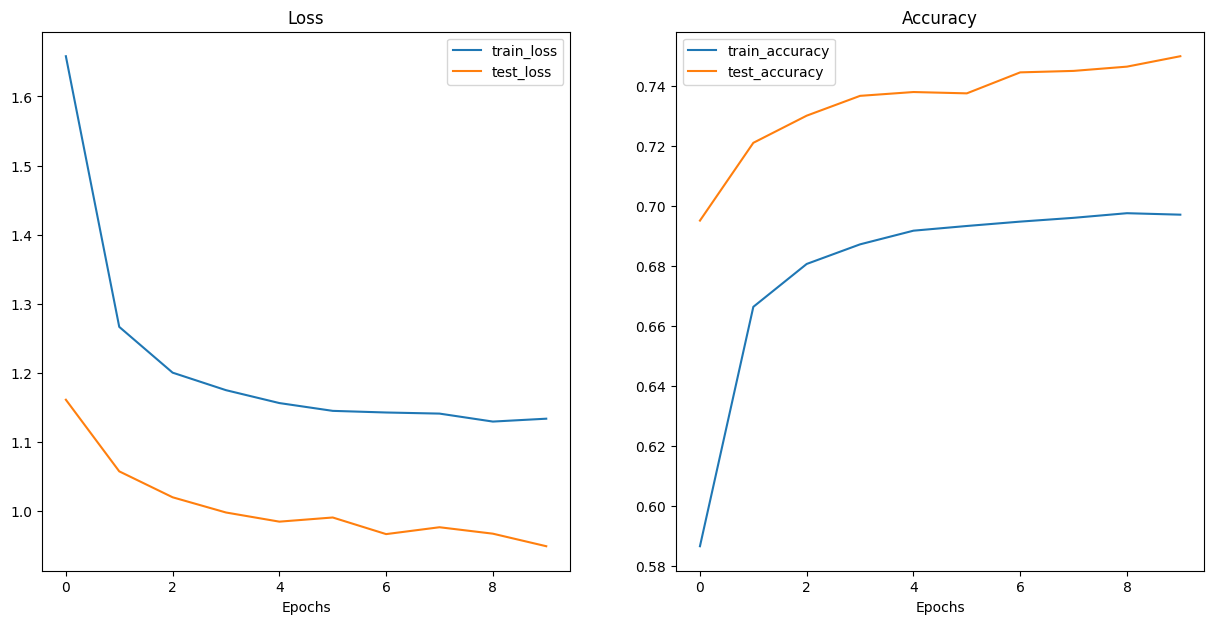

In [26]:
try:
  from helper_functions import plot_loss_curves
except:
  with open("helper_functions.py","wb") as f:
    import requests
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)


## 6. Make prediction on images from test set

In [27]:
from typing import List, Tuple
from pathlib import Path
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
  img=Image.open(image_path)

  if transform is not None:
    img_transform=transform
  else:
    img_transform=transforms.Compose([
                                       transforms.Resize(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485,0.456,0.406],
                                                            std=[0.229,0.224,0.225])
    ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      img_tensor=img_transform(img).unsqueeze(dim=0)
      img_pred=model(img_tensor.to(device))
      pred_probs=torch.softmax(img_pred,dim=1)
      pred_label=torch.argmax(pred_probs,dim=1)
      plt.figure()
      plt.imshow(img)
      plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_probs[0][pred_label]}")
      plt.axis(False)




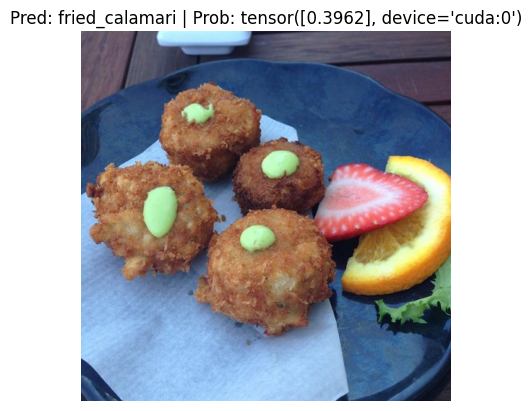

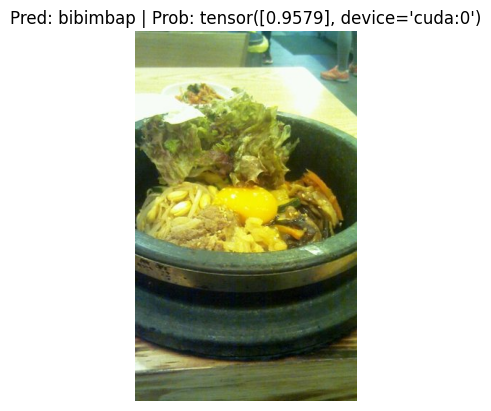

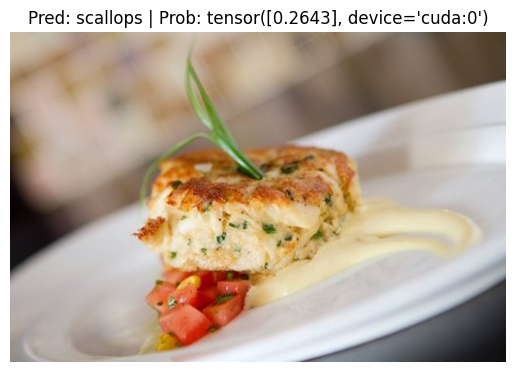

In [29]:
from pathlib import Path
import random

num_images_to_plot = 3

# gather all .jpg and .png under test_dir
all_images = [
    p for p in Path(test_dir).rglob("*")
    if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
]

# sample a few
test_image_path_sample = random.sample(all_images, k=num_images_to_plot)

# plot
for image_path in test_image_path_sample:
    pred_and_plot_image(
        model=model,
        class_names=class_names,
        image_path=image_path,
        image_size=(224, 224),
    )


### 6.1 Make prediction on custom images with model

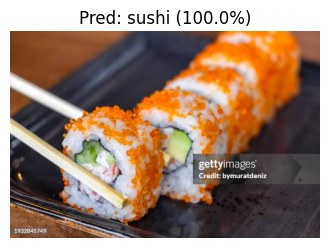

Predicted class: sushi (99.99%)


In [55]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path, transform, class_names, device="cpu"):
    """
    Loads an image, runs it through the model, and returns the predicted class name and probability.
    Also plots the image with its prediction.
    """
    # 1. Load and preprocess
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # shape [1, C, H, W]
    
    # 2. Model inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)            # raw logits, shape [1, num_classes]
        probs   = torch.softmax(outputs, dim=1)  # shape [1, num_classes]
        top_prob, top_idx = probs.topk(1, dim=1)
    
    # 3. Extract results
    pred_idx  = top_idx.item()
    pred_prob = top_prob.item()
    pred_label = class_names[pred_idx]
    
    # 4. Plot
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.title(f"Pred: {pred_label} ({pred_prob*100:.1f}%)")
    plt.axis(False)
    plt.show()
    
    return pred_label, pred_prob

# Example usage:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # ensure model is on the right device

img_path = "/kaggle/input/image1/query/shushi_1.jpg"  # or .jpg
label, prob = predict_image(
    model=model,
    image_path=img_path,
    transform=auto_transform,
    class_names=class_names,
    device=device
)
print(f"Predicted class: {label} ({prob*100:.2f}%)")


### 6.2 Make prediction on custom images with model.pth file

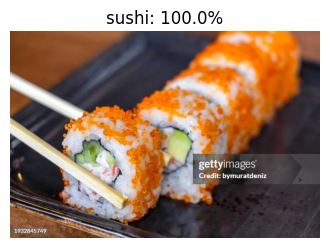

→ Predicted: sushi (99.99%)


In [59]:
import torch
import torch.nn as nn
from torchvision.models import swin_b, Swin_B_Weights
from PIL import Image
import matplotlib.pyplot as plt

# 1. Rebuild the model architecture
#    – no auto weights this time
model = swin_b(weights=None)

#    – replace the head with your 102-class classifier
in_features = model.head.in_features   #
model.head = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, out_features=len(class_names), bias=True)
)

# 2. Load your checkpoint
checkpoint_path = "/kaggle/working/checkpoints/swin_base_finetuned.pth"  
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# 3. Grab the same transforms you used at train time
weights = Swin_B_Weights.DEFAULT 
auto_transform = weights.transforms()

# 4. Define the prediction helper
def predict_image_from_saved(model, image_path, transform, class_names, device):
    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(tensor)
        probs  = torch.softmax(logits, dim=1)
        top_prob, top_idx = probs.topk(1, dim=1)
    label = class_names[top_idx.item()]
    conf  = top_prob.item()
    
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.title(f"{label}: {conf*100:.1f}%")
    plt.axis(False)
    plt.show()
    
    return label, conf


device = "cuda" if torch.cuda.is_available() else "cpu"
img_path = "/kaggle/input/image1/query/shushi_1.jpg"
pred_label, pred_conf = predict_image_from_saved(
    model, img_path, auto_transform, class_names, device
)
print(f"→ Predicted: {pred_label} ({pred_conf*100:.2f}%)")
